## Read timeseries HDF5 file and save data into text file for Comsol ... ##

In [1]:
# read / save displacement data from time-series file
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from mintpy.utils import readfile

work_dir = os.path.expanduser('~/insarlab/Galapagos/AlcedoSenDT128/mintpy/geo')
os.chdir(work_dir)
print('Go to directory:', work_dir)

date12 = '20160101_20171022'

Go to directory: /Users/yunjunz/insarlab/Galapagos/AlcedoSenDT128/mintpy/geo


In [2]:
# 1. save interferogram file in ROI_PAC format from time-series file
!save_roipac.py geo_timeseries_ECMWF_ramp_demErr.h5 {date12} -o {date12+'.unw'}
!mask.py {date12+'.unw'} -m geo_maskTempCoh.h5 -o {date12+'_msk.unw'}
#!subset.py {date12+'_msk.unw'} --lat -1.1 -0.7 --lon -91.55 -91.0 -o {date12+'_msk_sub.unw'}

read 20160101_20171022 from file geo_timeseries_ECMWF_ramp_demErr.h5
converting range to phase
write 20160101_20171022.unw
write 20160101_20171022.unw.rsc
masking 20160101_20171022 from 20160101_20171022.unw ...
write 20160101_20171022_msk.unw
write 20160101_20171022_msk.unw.rsc
Done.


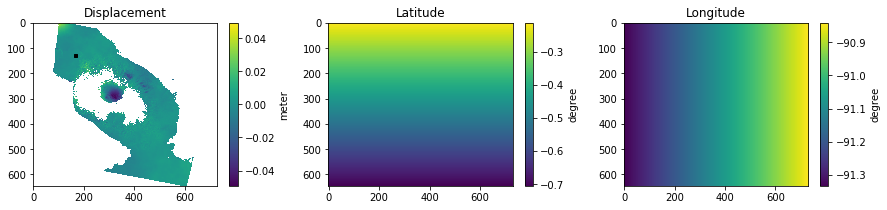

In [3]:
# 2. read deformation data in meter unit
unw_file = date12+'_msk.unw'
data, atr = readfile.read(unw_file)
data[data==0] = np.nan
data *= float(atr['WAVELENGTH']) / (-4. * np.pi) #convert phase in radian to displacement in meter

# 3. get lat/lon
lat0 = float(atr['Y_FIRST']);  lat_step = float(atr['Y_STEP']);  lat_num = int(atr['LENGTH'])
lon0 = float(atr['X_FIRST']);  lon_step = float(atr['X_STEP']);  lon_num = int(atr['WIDTH'])
lat1 = lat0 + lat_step * lat_num
lon1 = lon0 + lon_step * lon_num
lats, lons = np.mgrid[lat0:lat1:lat_num*1j,
                      lon0:lon1:lon_num*1j]

# 4. dislay
display = True
fig_file = '{}.png'.format(os.path.splitext(unw_file)[0])
if display:
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=[15, 3])
    im = ax1.imshow(data);   ax1.set_title('Displacement');  cbar = fig.colorbar(im, ax=ax1);  cbar.set_label('meter')
    im = ax2.imshow(lats);   ax2.set_title('Latitude');      cbar = fig.colorbar(im, ax=ax2);  cbar.set_label('degree')
    im = ax3.imshow(lons);   ax3.set_title('Longitude');     cbar = fig.colorbar(im, ax=ax3);  cbar.set_label('degree')
    ax1.plot(int(atr['REF_X']), int(atr['REF_Y']), 'ks', ms=3) # reference point
    #plt.savefig(fig_file, bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

In [4]:
# 5. save data into text file
out_file = os.path.splitext(unw_file)[0]+'.txt'
header = 'Displacement data from file {}\n'.format(unw_file)
header += 'InSAR file: {}\n'.format(unw_file)
header += 'Reference point in (Y, X): ({}, {})\n'.format(atr['REF_Y'], atr['REF_X'])
header += 'Reference point in (lat, lon): ({}, {})\n'.format(atr['REF_LAT'], atr['REF_LON'])
header += 'Latitude (deg)\tLongitude (deg)\t\tDisplacement (m)'

# skip pixels with Nan value -> irregular grid
skip_nan = True
if skip_nan:
    mask = ~np.isnan(data)
else:
    mask = np.ones(data.shape, np.bool_)

# save to text file
np.savetxt(out_file,
           np.hstack((lats[mask].reshape(-1, 1),
                      lons[mask].reshape(-1, 1),
                      data[mask].reshape(-1, 1))),
           fmt='%s',
           header=header,
           delimiter='\t')
print('saved to '+out_file)

saved to 20160101_20171022_msk.txt
